Calcolo GARCH, DCC
Tabella GARCH
Tabella DCC
Grafici

In [ ]:
!pip install arch numpy pandas matplotlib scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from arch import arch_model

GARCH_RESULTS_SUMMARY = {}
DCC_RESULTS_SUMMARY = {}
RESCALE_FACTOR = 100

def fit_univariate_garch(series, name):
    model = arch_model(series, vol='GARCH', p=1, q=1, mean='zero', rescale=False)
    res = model.fit(disp='off')
    ω, α, β = res.params['omega'], res.params['alpha[1]'], res.params['beta[1]']
    GARCH_RESULTS_SUMMARY[name] = {
        'omega': ω * RESCALE_FACTOR**2,
        'alpha': α,
        'beta': β,
        'persistence': α + β
    }
    return res.conditional_volatility, res

def dcc_garch(returns):
    T, N = returns.shape
    vol, resid = np.zeros((T, N)), np.zeros((T, N))
    for i, col in enumerate(returns.columns):
        v, _ = fit_univariate_garch(returns.iloc[:, i], col)
        vol[:, i], resid[:, i] = v, returns.iloc[:, i].values / v

    Q_bar = np.cov(resid.T)

    def ll(params):
        a, b = params
        Q = Q_bar.copy()
        L = 0
        for t in range(1, T):
            z = resid[t - 1].reshape(-1, 1)
            Q = (1 - a - b) * Q_bar + a * (z @ z.T) + b * Q
            D = np.diag(1 / np.sqrt(np.diag(Q)))
            R = D @ Q @ D
            L += np.log(np.linalg.det(R)) + resid[t].T @ np.linalg.inv(R) @ resid[t]
        return L

    res = minimize(ll, x0=[0.01, 0.98],
                   bounds=[(1e-6, 1 - 1e-6)] * 2,
                   constraints={'type': 'ineq', 'fun': lambda x: 1 - sum(x)})
    a, b = res.x

    Q, dcc_series = Q_bar.copy(), []
    for t in range(1, T):
        z = resid[t - 1].reshape(-1, 1)
        Q = (1 - a - b) * Q_bar + a * (z @ z.T) + b * Q
        D = np.diag(1 / np.sqrt(np.diag(Q)))
        R = D @ Q @ D
        dcc_series.append(R[0, 1])

    return dcc_series, res

def analyze_pair(df, x, y, plot=False, start=None):
    data = df[[x, y]].dropna()
    if start is not None:
        data = data.loc[data.index >= pd.to_datetime(start)]

    r = np.log(data / data.shift(1)).dropna()
    rs = r * RESCALE_FACTOR
    corr = r[x].corr(r[y])
    print(f"\nAnalisi: {x} - {y} (corr. statica {corr:.4f})")

    dcc_series, res = dcc_garch(rs)
    a, b = res.x
    DCC_RESULTS_SUMMARY[f"{x} - {y}"] = {
        'Correlazione Statica': corr,
        'alpha_DCC': a,
        'beta_DCC': b,
        'alpha_DCC + beta_DCC (Persistenza)': a + b
    }

    if plot:
        plt.figure(figsize=(18, 10))
        for w, c in zip([252, 126, 63], ['green', 'orange', 'purple']):
            roll = r[x].rolling(w).corr(r[y]).dropna()
            plt.subplot(2, 1, 1)
            plt.plot(roll.index, roll, label=f'Rolling {w}g', color=c)
        plt.title(f'Correlazione Rolling: {x} - {y}')
        plt.xlabel('Data'); plt.ylabel('Correlazione')
        plt.grid(True); plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(r.index[1:], dcc_series, label='DCC Correlation', color='blue')
        plt.title(f'DCC-GARCH: Correlazione dinamica {x} - {y}')
        plt.xlabel('Data'); plt.ylabel('Correlazione')
        plt.grid(True); plt.legend()
        plt.tight_layout()
        plt.show()

df = pd.read_excel('/content/indici_tesi_all.xlsx')
df['Data'] = pd.to_datetime(df['Date'])
df.set_index('Data', inplace=True)
df['CSI300'] = df['CSI300'].replace(0, np.nan)

indici = ['SP500', 'STOXX600', 'NIKKEI225', 'Sensex', 'CSI300',
          'Gold', 'Silver', 'Treasury 10y', 'Bitcoin']

pairs = [(i, j) for i in indici for j in indici[indici.index(i)+1:]
         if ('SP500' in (i, j) or 'STOXX600' in (i, j)) and set((i, j)) != {'Gold', 'Silver'}]

for p in pairs:
    analyze_pair(df.copy(), p[0], p[1], plot=True)
analyze_pair(df.copy(), 'Gold', 'Silver', plot=True)

# Tabella GARCH(1,1)
garch = pd.DataFrame.from_dict(GARCH_RESULTS_SUMMARY, orient='index')
garch = garch.rename(columns={'omega': 'α₀', 'alpha': 'α₁', 'beta': 'β₁', 'persistence': 'α₁ + β₁'})
garch = garch.reindex(indici)
garch['α₁ + β₁'] = garch['α₁ + β₁'].apply(lambda x: f"{x:.4f} ({x*100:.2f}%)")
garch[['α₀', 'α₁', 'β₁']] = garch[['α₀', 'α₁', 'β₁']].applymap(lambda x: f"{x:.4f}")
print("\nTabella 5.1 – Parametri GARCH(1,1)")
print(garch.to_string())

# Tabella DCC-GARCH
dcc = pd.DataFrame.from_dict(DCC_RESULTS_SUMMARY, orient='index')
dcc = dcc.rename(columns={'Correlazione Statica': 'Corr. Statica',
                          'alpha_DCC': 'α_DCC', 'beta_DCC': 'β_DCC',
                          'alpha_DCC + beta_DCC (Persistenza)': 'α_DCC + β_DCC'})
sel = [f"SP500 - {i}" for i in indici if i != 'SP500'] + \
      [f"STOXX600 - {i}" for i in indici[indici.index('NIKKEI225'):] if i != 'STOXX600']
dcc = dcc.loc[dcc.index.isin(sel)].reindex(sel)
dcc[['Corr. Statica', 'α_DCC', 'β_DCC']] = dcc[['Corr. Statica', 'α_DCC', 'β_DCC']].applymap(lambda x: f"{x:.4f}")
dcc['α_DCC + β_DCC'] = dcc['α_DCC + β_DCC'].apply(lambda x: f"{x:.4f} ({x*100:.2f}%)")
print("\nTabella 5.2 – Parametri DCC-GARCH")
print(dcc.to_string())


Output hidden; open in https://colab.research.google.com to view.

ANALISI DI TAIL DEPENDENCE


Tabella: Lower Tail Dependence (α=5%)
               SP500    STOXX600    NIKKEI225    Sensex    CSI300    Gold    Silver    Treasury 10y    Bitcoin
   SP500      100.00     43.49        17.10      20.82     11.52     8.92     8.18        30.11         16.13
  STOXX600     43.49     100.00       28.25      36.80     18.22    13.01    13.01        24.91         11.29
 NIKKEI225     17.10     28.25       100.00      26.77     20.82    12.27    15.61        10.04         9.14
   Sensex      20.82     36.80        26.77      100.00    20.82    17.47    17.47        13.75         6.45
   CSI300      11.52     18.22        20.82      20.82     100.00   11.52    13.75         7.06         9.14
    Gold       8.92      13.01        12.27      17.47     11.52    100.00   30.48         5.58         6.99
   Silver      8.18      13.01        15.61      17.47     13.75    30.48    100.00        5.58         10.22
Treasury 10y   30.11     24.91        10.04      13.75      7.06     5.58     5.58  

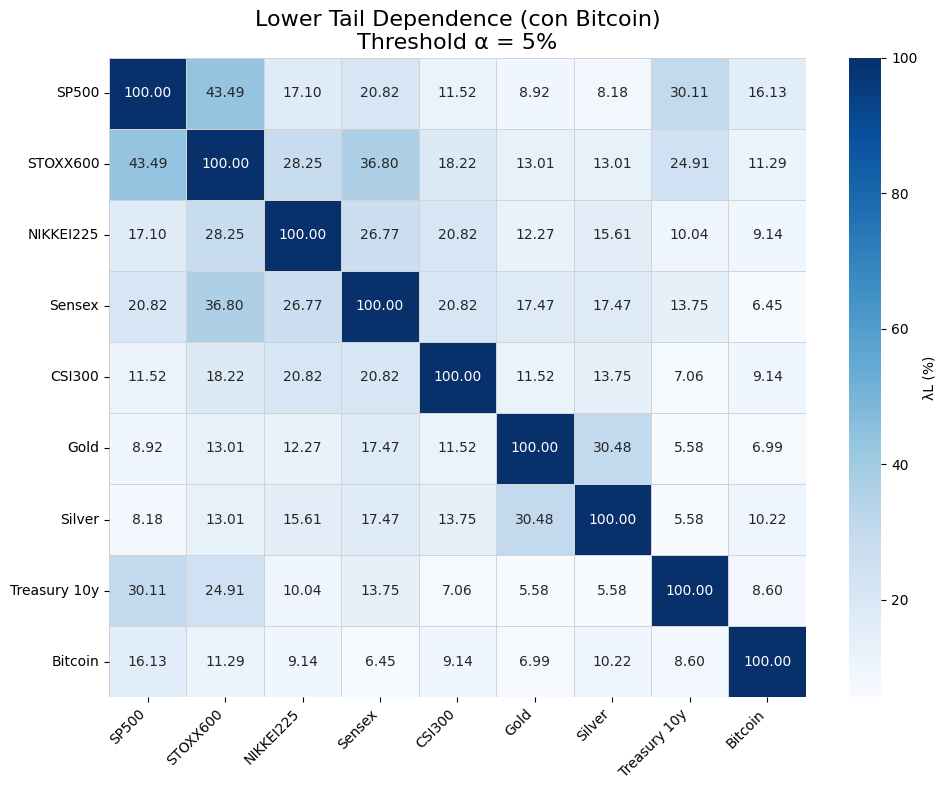


Tabella: Lower Tail Dependence (α=1%)
               SP500    STOXX600    NIKKEI225    Sensex    CSI300    Gold    Silver    Treasury 10y    Bitcoin
   SP500      100.00     48.15        18.52      24.07      5.56     9.26     1.85        25.93         10.53
  STOXX600     48.15     100.00       25.93      35.19      7.41    14.81     7.41        33.33         2.63
 NIKKEI225     18.52     25.93       100.00      25.93     12.96     7.41     9.26         7.41         2.63
   Sensex      24.07     35.19        25.93      100.00    12.96    12.96     7.41        12.96         5.26
   CSI300      5.56       7.41        12.96      12.96     100.00    3.70     3.70         0.00         0.00
    Gold       9.26      14.81        7.41       12.96      3.70    100.00   24.07         5.56         7.89
   Silver      1.85       7.41        9.26        7.41      3.70    24.07    100.00        5.56         5.26
Treasury 10y   25.93     33.33        7.41       12.96      0.00     5.56     5.56    

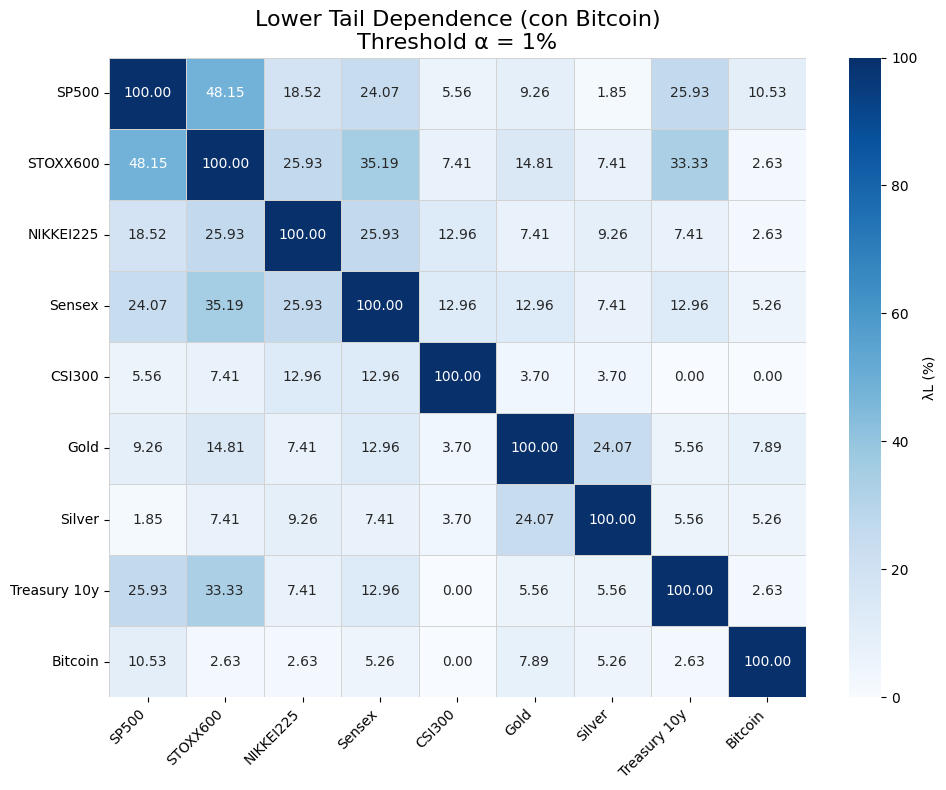


Tabella: Lower Tail Dependence (α=5%)
               SP500    STOXX600    NIKKEI225    Sensex    CSI300    Gold    Silver    Treasury 10y    Bitcoin
   SP500      100.00     43.49        17.10      20.82     11.52     8.92     8.18        30.11         16.13
  STOXX600     43.49     100.00       28.25      36.80     18.22    13.01    13.01        24.91         11.29
 NIKKEI225     17.10     28.25       100.00      26.77     20.82    12.27    15.61        10.04         9.14
   Sensex      20.82     36.80        26.77      100.00    20.82    17.47    17.47        13.75         6.45
   CSI300      11.52     18.22        20.82      20.82     100.00   11.52    13.75         7.06         9.14
    Gold       8.92      13.01        12.27      17.47     11.52    100.00   30.48         5.58         6.99
   Silver      8.18      13.01        15.61      17.47     13.75    30.48    100.00        5.58         10.22
Treasury 10y   30.11     24.91        10.04      13.75      7.06     5.58     5.58  

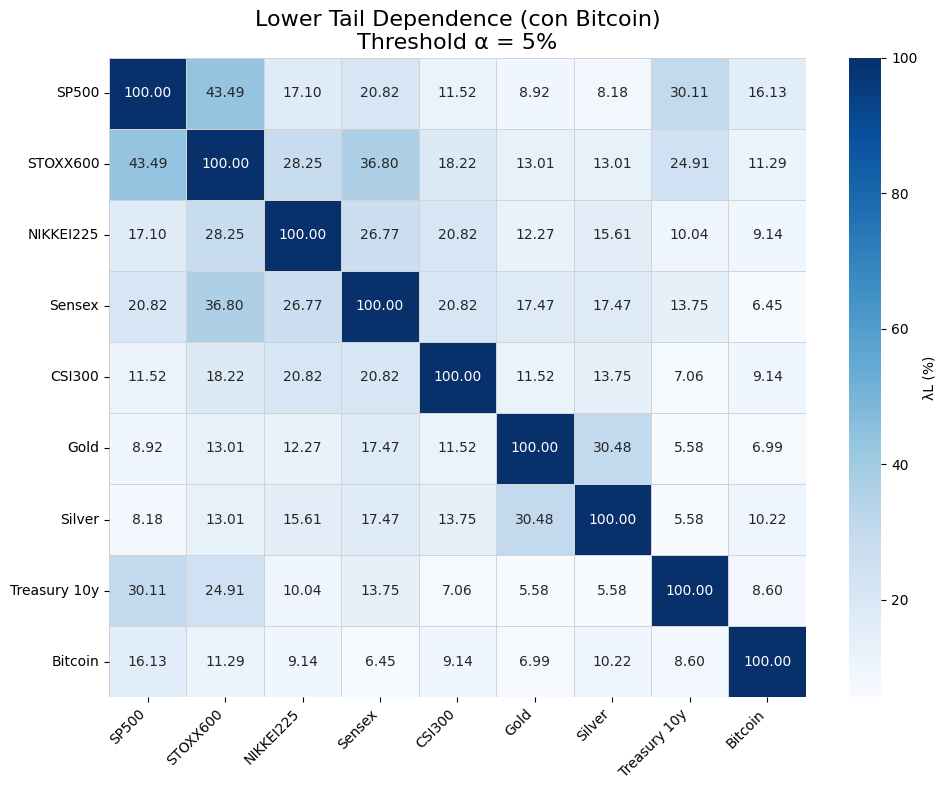


Tabella: Lower Tail Dependence (α=1%)
               SP500    STOXX600    NIKKEI225    Sensex    CSI300    Gold    Silver    Treasury 10y    Bitcoin
   SP500      100.00     48.15        18.52      24.07      5.56     9.26     1.85        25.93         10.53
  STOXX600     48.15     100.00       25.93      35.19      7.41    14.81     7.41        33.33         2.63
 NIKKEI225     18.52     25.93       100.00      25.93     12.96     7.41     9.26         7.41         2.63
   Sensex      24.07     35.19        25.93      100.00    12.96    12.96     7.41        12.96         5.26
   CSI300      5.56       7.41        12.96      12.96     100.00    3.70     3.70         0.00         0.00
    Gold       9.26      14.81        7.41       12.96      3.70    100.00   24.07         5.56         7.89
   Silver      1.85       7.41        9.26        7.41      3.70    24.07    100.00        5.56         5.26
Treasury 10y   25.93     33.33        7.41       12.96      0.00     5.56     5.56    

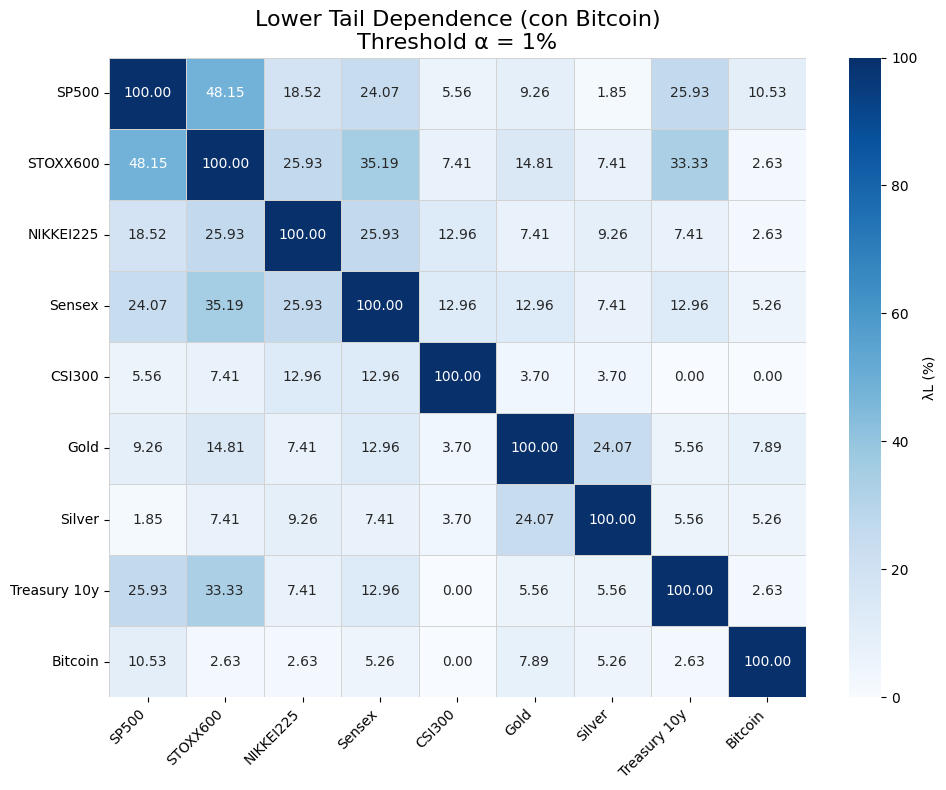


Tabella: Differenza Tail Dependence (λ(5%) - λ(1%)) con Bitcoin
               SP500    STOXX600    NIKKEI225    Sensex    CSI300    Gold    Silver    Treasury 10y    Bitcoin
   SP500       0.00      -4.65        -1.42      -3.26      5.97    -0.34     6.33         4.19         5.60
  STOXX600     -4.65      0.00        2.33        1.62     10.81    -1.80     5.60        -8.43         8.66
 NIKKEI225     -1.42      2.33        0.00        0.84      7.85     4.86     6.35         2.63         6.51
   Sensex      -3.26      1.62        0.84        0.00      7.85     4.51    10.06         0.79         1.19
   CSI300      5.97      10.81        7.85        7.85      0.00     7.82    10.05         7.06         9.14
    Gold       -0.34     -1.80        4.86        4.51      7.82     0.00     6.41         0.02         -0.91
   Silver      6.33       5.60        6.35       10.06     10.05     6.41     0.00         0.02         4.95
Treasury 10y   4.19      -8.43        2.63        0.79      

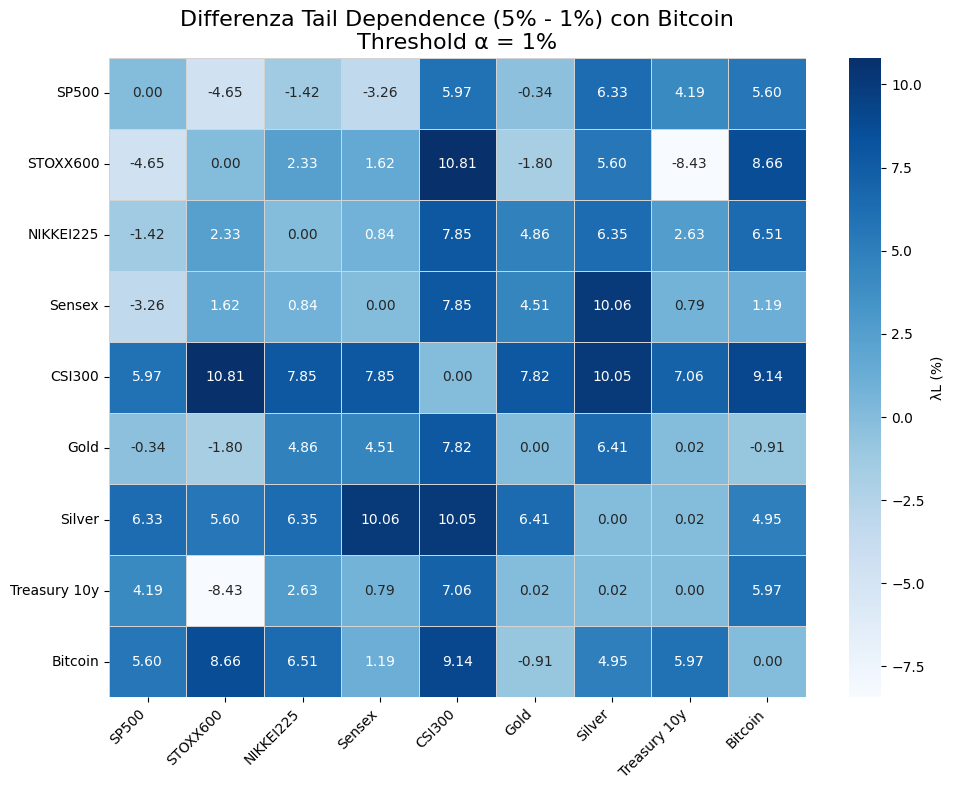

In [4]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

warnings.filterwarnings("ignore")

FILE_NAME = "indici_tesi_all.xlsx"

def carica_rendimenti():
    df = pd.read_excel(FILE_NAME)
    df["Data"] = pd.to_datetime(df["Date"])
    df.set_index("Data", inplace=True)
    df.drop(columns=["Date"], errors="ignore", inplace=True)
    if "CSI300" in df.columns:
        df["CSI300"] = df["CSI300"].replace(0, np.nan)
    returns = np.log(df / df.shift(1))
    return returns.dropna(how="all")

def tail_dependence(df, alpha=0.05):
    assets = df.columns
    n = len(assets)
    M = pd.DataFrame(np.zeros((n, n)), index=assets, columns=assets)
    for i in range(n):
        for j in range(i, n):
            Q_i, Q_j = df.iloc[:, i].quantile(alpha), df.iloc[:, j].quantile(alpha)
            tail_i, tail_j = df.iloc[:, i] < Q_i, df.iloc[:, j] < Q_j
            simult = (tail_i & tail_j).sum()
            λ = 1.0 if i == j else simult / tail_i.sum() if tail_i.sum() > 0 else 0
            M.iloc[i, j] = M.iloc[j, i] = λ
    return M

def heatmap_tail(matrix, title, alpha):
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        matrix * 100,
        annot=True, fmt=".2f", cmap="Blues",
        linewidths=0.5, linecolor="lightgray",
        cbar_kws={"label": "λL (%)"}
    )
    plt.title(f"{title}\nThreshold α = {alpha*100:.0f}%", fontsize=16)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

df_ret = carica_rendimenti()

indici = ["SP500", "STOXX600", "NIKKEI225", "Sensex",
          "CSI300", "Gold", "Silver", "Treasury 10y"]
btc = "Bitcoin"

mat_5 = tail_dependence(df_ret[indici].dropna(), alpha=0.05)
mat_1 = tail_dependence(df_ret[indici].dropna(), alpha=0.01)

if btc in df_ret.columns:
    for α, base in [(0.05, mat_5), (0.01, mat_1)]:
        M = base.copy()
        M[btc] = np.nan
        M.loc[btc] = np.nan
        M.loc[btc, btc] = 1.0

        for col in indici:
            sub = df_ret[[btc, col]].dropna()
            λ = tail_dependence(sub, α).loc[btc, col] if len(sub) > 50 else np.nan
            M.loc[btc, col] = M.loc[col, btc] = λ

        print(f"\nTabella: Lower Tail Dependence (α={α*100:.0f}%)")
        print(tabulate(
            M * 100,
            headers="keys",
            tablefmt="plain",
            showindex=True,
            stralign="center",
            numalign="center",
            floatfmt=".2f"
        ))
        heatmap_tail(M, "Lower Tail Dependence (con Bitcoin)", α)

# # Salva le versioni con Bitcoin
mat_5_btc = None
mat_1_btc = None

for α, base in [(0.05, mat_5), (0.01, mat_1)]:
    M = base.copy()
    M[btc] = np.nan
    M.loc[btc] = np.nan
    M.loc[btc, btc] = 1.0

    for col in indici:
        sub = df_ret[[btc, col]].dropna()
        λ = tail_dependence(sub, α).loc[btc, col] if len(sub) > 50 else np.nan
        M.loc[btc, col] = M.loc[col, btc] = λ

    if α == 0.05:
        mat_5_btc = M.copy()
    else:
        mat_1_btc = M.copy()

    print(f"\nTabella: Lower Tail Dependence (α={α*100:.0f}%)")
    print(tabulate(
        M * 100,
        headers="keys",
        tablefmt="plain",
        showindex=True,
        stralign="center",
        numalign="center",
        floatfmt=".2f"
    ))
    heatmap_tail(M, "Lower Tail Dependence (con Bitcoin)", α)

# Ora calcola anche la differenza comprensiva di BTC
diff_btc = mat_5_btc - mat_1_btc

print("\nTabella: Differenza Tail Dependence (λ(5%) - λ(1%)) con Bitcoin")
print(tabulate(
    diff_btc * 100,
    headers="keys",
    tablefmt="plain",
    showindex=True,
    stralign="center",
    numalign="center",
    floatfmt=".2f"
))
heatmap_tail(diff_btc, "Differenza Tail Dependence (5% - 1%) con Bitcoin", 0.01)


TAIL DEPENDENCE PT.2 CON COPULE


T-Copula λL (%)
                SP500    STOXX600    NIKKEI225    Sensex    CSI300    Gold    Silver    Treasury 10y    Bitcoin
SP500          100.00       32.96        10.39     11.04      9.75   12.32      8.90           25.86      15.89
STOXX600        32.96      100.00         9.40     13.11      9.39   14.47     10.52           15.65      12.61
NIKKEI225       10.39        9.40       100.00     13.25      9.84    9.27     11.95            4.42      10.34
Sensex          11.04       13.11        13.25    100.00     10.82   11.34     12.48            2.87       9.52
CSI300           9.75        9.39         9.84     10.82    100.00   11.22     12.12            2.11      16.80
Gold            12.32       14.47         9.27     11.34     11.22  100.00     20.60            4.15      14.93
Silver           8.90       10.52        11.95     12.48     12.12   20.60    100.00            2.30      13.22
Treasury 10y    25.86       15.65         4.42      2.87      2.11    4.15      2.30   

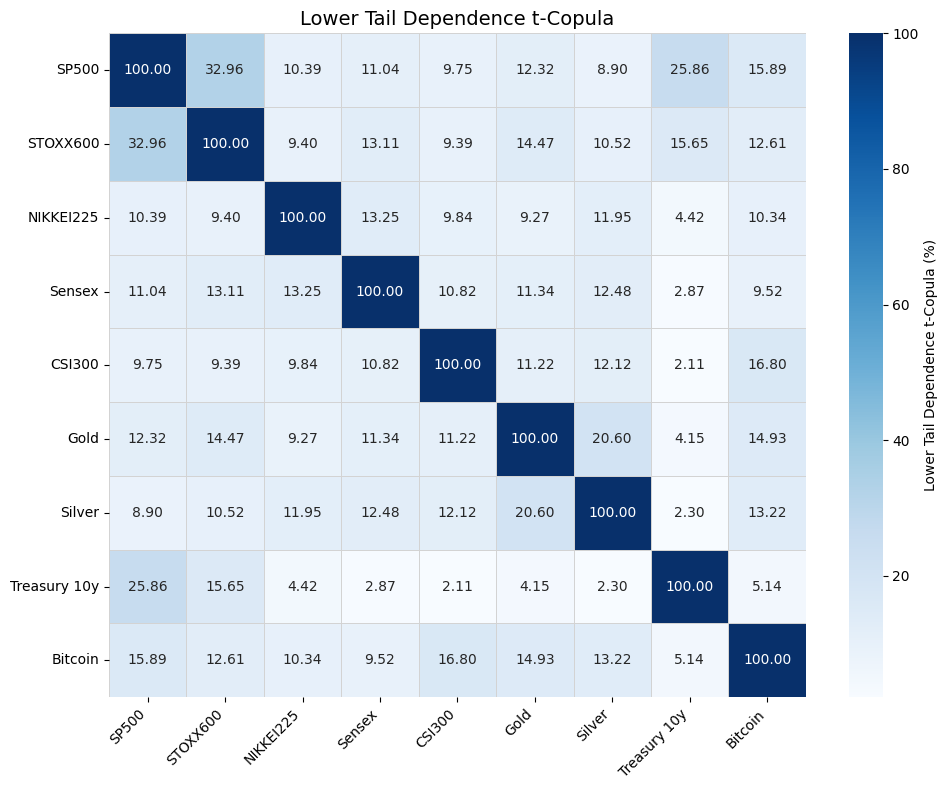


T-Copula Rho
                SP500    STOXX600    NIKKEI225    Sensex    CSI300     Gold    Silver    Treasury 10y    Bitcoin
SP500          1.0000      0.6703       0.2089    0.3082    0.1569   0.0198    0.0741          0.3451     0.2333
STOXX600       0.6703      1.0000       0.4182    0.5033    0.2469   0.0321    0.1513          0.3035     0.1358
NIKKEI225      0.2089      0.4182       1.0000    0.4437    0.3948  -0.0156    0.1415          0.1125    -0.0358
Sensex         0.3082      0.5033       0.4437    1.0000    0.3009   0.0910    0.2425          0.1367     0.0182
CSI300         0.1569      0.2469       0.3948    0.3009    1.0000   0.1025    0.1982          0.0735     0.0679
Gold           0.0198      0.0321      -0.0156    0.0910    0.1025   1.0000    0.5891         -0.2356     0.1065
Silver         0.0741      0.1513       0.1415    0.2425    0.1982   0.5891    1.0000          0.0047     0.0717
Treasury 10y   0.3451      0.3035       0.1125    0.1367    0.0735  -0.2356    0.0

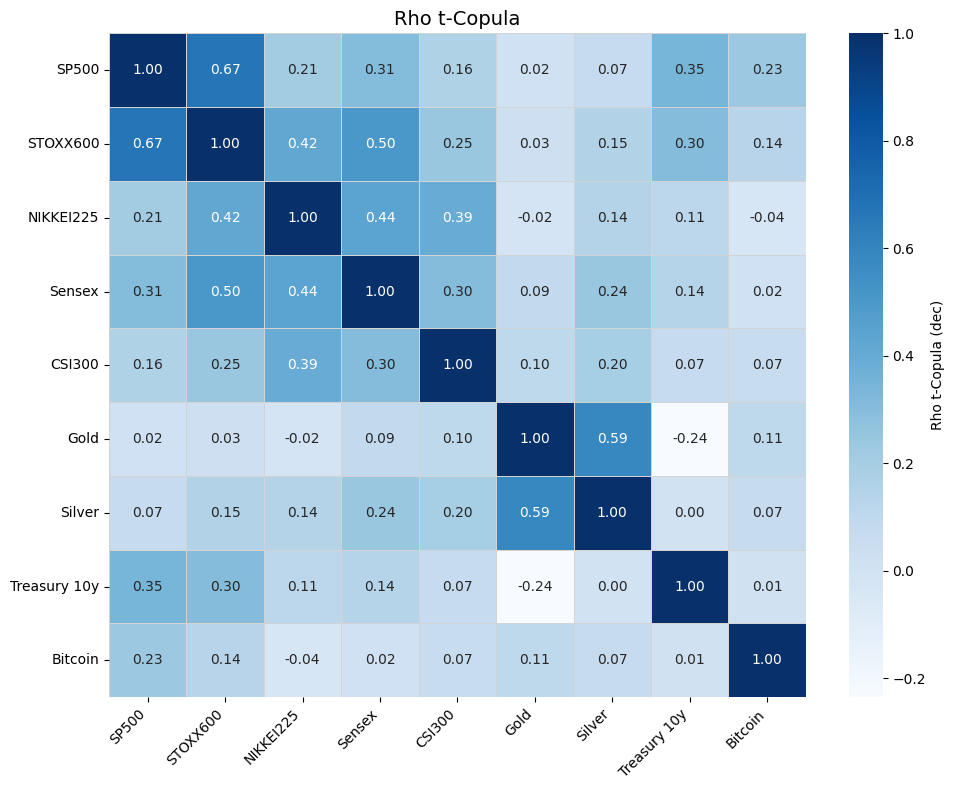


Clayton λL (%)
                SP500    STOXX600    NIKKEI225    Sensex    CSI300    Gold    Silver    Treasury 10y    Bitcoin
SP500          100.00       54.34         8.56     16.80      4.74    0.07      0.61           29.55      15.13
STOXX600        54.34      100.00        28.30     37.45     12.06    0.13      2.83           20.26       6.46
NIKKEI225        8.56       28.30       100.00     31.86     27.74    0.02      5.48            1.09       0.98
Sensex          16.80       37.45        31.86    100.00     19.40    2.00     11.70            3.00       1.67
CSI300           4.74       12.06        27.74     19.40    100.00    4.49     10.95            0.33       8.43
Gold             0.07        0.13         0.02      2.00      4.49  100.00     47.70            0.00       4.44
Silver           0.61        2.83         5.48     11.70     10.95   47.70    100.00            0.00       4.94
Treasury 10y    29.55       20.26         1.09      3.00      0.33    0.00      0.00    

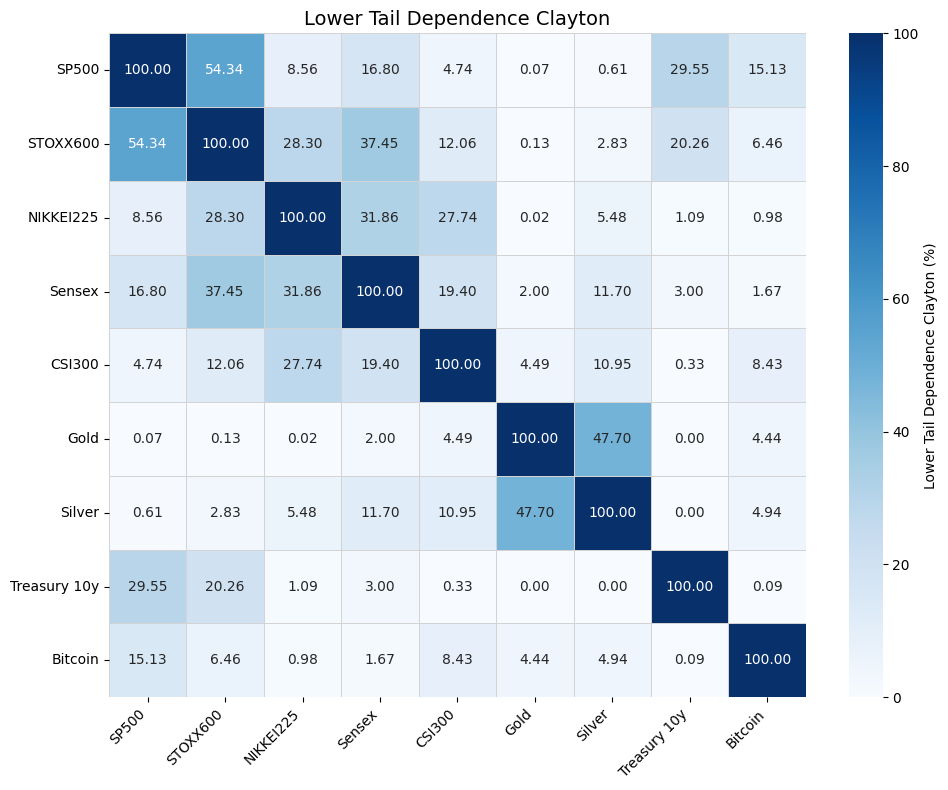


Clayton Theta
                SP500    STOXX600    NIKKEI225    Sensex    CSI300    Gold    Silver    Treasury 10y    Bitcoin
SP500          1.0000      1.1363       0.2820    0.3886    0.2273  0.0953    0.1357          0.5686     0.3670
STOXX600       1.1363      1.0000       0.5491    0.7057    0.3276  0.1044    0.1944          0.4341     0.2530
NIKKEI225      0.2820      0.5491       1.0000    0.6060    0.5406  0.0791    0.2386          0.1535     0.1497
Sensex         0.3886      0.7057       0.6060    1.0000    0.4227  0.1772    0.3230          0.1976     0.1693
CSI300         0.2273      0.3276       0.5406    0.4227    1.0000  0.2233    0.3134          0.1210     0.2802
Gold           0.0953      0.1044       0.0791    0.1772    0.2233  1.0000    0.9364          0.0001     0.2225
Silver         0.1357      0.1944       0.2386    0.3230    0.3134  0.9364    1.0000          0.0417     0.2305
Treasury 10y   0.5686      0.4341       0.1535    0.1976    0.1210  0.0001    0.0417     

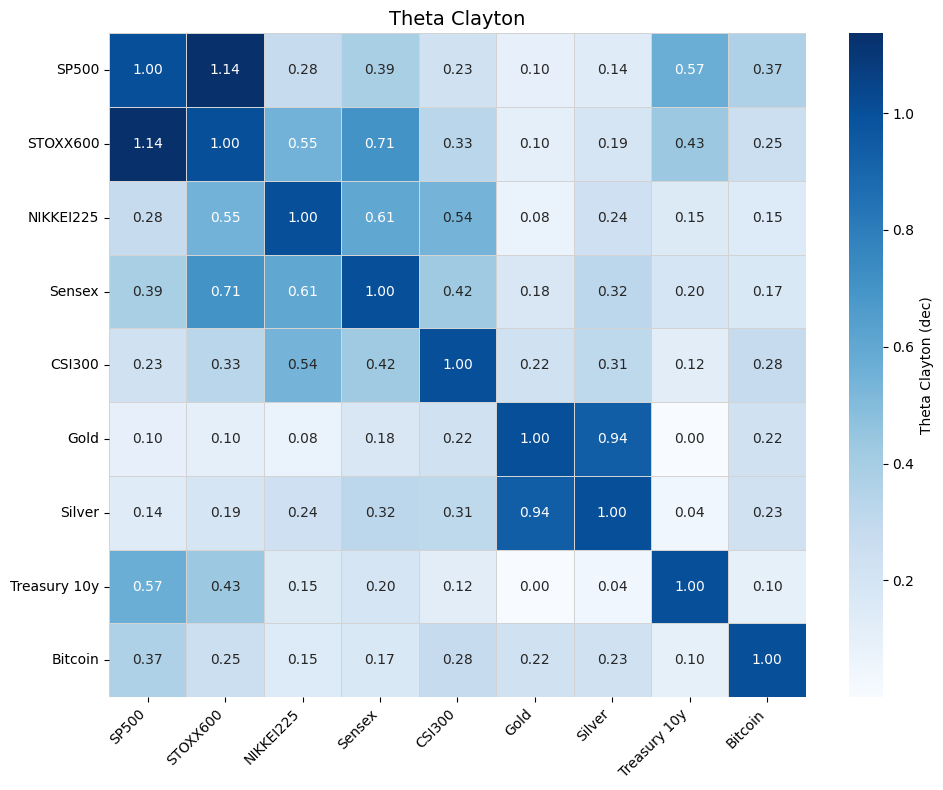

In [ ]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from scipy.stats import t
from scipy.optimize import minimize
from math import log, gamma, sqrt
from tabulate import tabulate

warnings.filterwarnings("ignore")

FILE_NAME = "indici_tesi_all.xlsx"
RESCALE_FACTOR = 100
MIN_NU = 2.01
MIN_OBS_PAIR = 50

def carica_rendimenti():
    df = pd.read_excel(FILE_NAME)
    df["Data"] = pd.to_datetime(df["Date"])
    df.set_index("Data", inplace=True)
    df.drop(columns=["Date"], errors="ignore", inplace=True)
    if "CSI300" in df.columns:
        df["CSI300"] = df["CSI300"].replace(0, np.nan)
    returns = np.log(df / df.shift(1)) * RESCALE_FACTOR
    return returns

def garch_pseudo(series1, series2):
    pseudo_list = []
    for s in [series1, series2]:
        s = s.dropna()
        if len(s) < 20:
            return pd.DataFrame()
        try:
            model = arch_model(s, vol="Garch", p=1, q=1, mean="Zero", dist="StudentsT", rescale=False)
            res = model.fit(disp="off")
            std_resid = res.resid / res.conditional_volatility
            nu = res.params.get("nu", 5.0)
            cdf_vals = t.cdf(std_resid.values, df=float(nu))
            pseudo_list.append(pd.Series(cdf_vals, index=std_resid.index, name=s.name))
        except Exception:
            return pd.DataFrame()
    return pd.concat(pseudo_list, axis=1).dropna()

def t_loglik(params, U, V):
    rho, nu = params
    if not (MIN_NU < nu < 200 and -0.999 < rho < 0.999):
        return 1e10
    x, y = t.ppf(U, df=nu), t.ppf(V, df=nu)
    denom = 1 - rho**2
    qf = (x**2 - 2*rho*x*y + y**2) / denom
    const = log(gamma((nu + 2)/2)) + log(gamma(nu/2)) - 2*log(gamma((nu + 1)/2))
    term = -(nu + 2)/2 * np.log1p(qf / nu) + (nu + 1)/2 * (np.log1p(x**2 / nu) + np.log1p(y**2 / nu)) - 0.5*np.log(denom)
    return -np.sum(term + const)

def t_lambda_L(rho, nu):
    q = sqrt((nu + 1)*(1 - rho)/(1 + rho))
    return 2 * t.cdf(-q, df=nu + 1)

def clayton_loglik(theta_arr, U, V):
    theta = float(theta_arr[0])
    if theta <= 0:
        return 1e10
    try:
        part1 = np.log(1 + theta)
        part2 = (-1 - theta) * (np.log(U) + np.log(V))
        part3 = -(2 + 1/theta) * np.log(U**(-theta) + V**(-theta) - 1)
        return -np.sum(part1 + part2 + part3)
    except Exception:
        return 1e10

def clayton_lambda_L(theta):
    try:
        return 2 ** (-1 / theta)
    except Exception:
        return np.nan

def stima_coppia(s1, s2):
    U_data = garch_pseudo(s1, s2)
    if U_data.empty or len(U_data) < MIN_OBS_PAIR:
        return np.nan, np.nan, np.nan, np.nan
    U, V = U_data.iloc[:, 0].values, U_data.iloc[:, 1].values
    rho0 = np.corrcoef(U, V)[0, 1]
    init_t = [rho0 if not np.isnan(rho0) else 0.0, 6.0]
    try:
        res_t = minimize(t_loglik, x0=init_t, args=(U, V), method="SLSQP",
                         bounds=[(-0.999, 0.999), (MIN_NU, 200)], options={"disp": False})
        if res_t.success:
            rho, nu = res_t.x
            lambda_t = t_lambda_L(rho, nu)
        else:
            rho = nu = lambda_t = np.nan
    except Exception:
        rho = nu = lambda_t = np.nan
    try:
        tau = np.corrcoef(t.ppf(U, df=5), t.ppf(V, df=5))[0, 1]
        theta_start = (2*tau)/(1 - tau) if tau > 0 else 0.1
        res_c = minimize(clayton_loglik, x0=[theta_start], args=(U, V), method="SLSQP",
                         bounds=[(1e-4, 200)], options={"disp": False})
        if res_c.success:
            theta = float(res_c.x[0])
            lambda_c = clayton_lambda_L(theta)
        else:
            theta = lambda_c = np.nan
    except Exception:
        theta = lambda_c = np.nan
    return lambda_t, rho, lambda_c, theta

def analizza_copule(df):
    assets = df.columns
    n = len(assets)
    L_t = pd.DataFrame(np.nan, index=assets, columns=assets)
    rho_t = pd.DataFrame(np.nan, index=assets, columns=assets)
    L_c = pd.DataFrame(np.nan, index=assets, columns=assets)
    theta_c = pd.DataFrame(np.nan, index=assets, columns=assets)
    for i in range(n):
        for j in range(i, n):
            a1, a2 = assets[i], assets[j]
            if i == j:
                L_t.loc[a1, a2] = rho_t.loc[a1, a2] = L_c.loc[a1, a2] = theta_c.loc[a1, a2] = 1.0
                continue
            sub = df[[a1, a2]].dropna()
            if len(sub) < MIN_OBS_PAIR:
                continue
            λ_t, ρ, λ_c, θ = stima_coppia(sub.iloc[:, 0], sub.iloc[:, 1])
            for M, val in zip([L_t, rho_t, L_c, theta_c], [λ_t, ρ, λ_c, θ]):
                M.loc[a1, a2] = M.loc[a2, a1] = val
    return L_t, rho_t, L_c, theta_c

def heatmap(M, title, unit="%"):
    plt.figure(figsize=(10, 8))
    display = M * 100 if unit == "%" else M
    sns.heatmap(display, annot=True, fmt=".2f", cmap="Blues",
                linewidths=0.5, linecolor="lightgray",
                cbar_kws={"label": f"{title} ({unit})"})
    plt.title(title, fontsize=14)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

df_ret = carica_rendimenti()
indici = ["SP500", "STOXX600", "NIKKEI225", "Sensex", "CSI300", "Gold", "Silver", "Treasury 10y"]
btc = "Bitcoin"

base = df_ret[indici].dropna()
L_t_base, rho_t_base, L_c_base, theta_c_base = analizza_copule(base)

assets = indici + ([btc] if btc in df_ret.columns else [])
L_t = pd.DataFrame(np.nan, index=assets, columns=assets)
rho_t = pd.DataFrame(np.nan, index=assets, columns=assets)
L_c = pd.DataFrame(np.nan, index=assets, columns=assets)
theta_c = pd.DataFrame(np.nan, index=assets, columns=assets)

for i in indici:
    for j in indici:
        for M_full, M_base in zip([L_t, rho_t, L_c, theta_c],
                                  [L_t_base, rho_t_base, L_c_base, theta_c_base]):
            M_full.loc[i, j] = M_base.loc[i, j]

if btc in df_ret.columns:
    L_t.loc[btc, btc] = rho_t.loc[btc, btc] = L_c.loc[btc, btc] = theta_c.loc[btc, btc] = 1.0
    for c in indici:
        sub = df_ret[[btc, c]].dropna()
        if len(sub) < MIN_OBS_PAIR:
            λ_t = ρ = λ_c = θ = np.nan
        else:
            λ_t, ρ, λ_c, θ = stima_coppia(sub.iloc[:, 0], sub.iloc[:, 1])
        for M, val in zip([L_t, rho_t, L_c, theta_c], [λ_t, ρ, λ_c, θ]):
            M.loc[btc, c] = M.loc[c, btc] = val

print("\nT-Copula λL (%)")
print(tabulate(L_t * 100, headers="keys", tablefmt="plain", showindex=True, floatfmt=".2f"))
heatmap(L_t, "Lower Tail Dependence t-Copula")

print("\nT-Copula Rho")
print(tabulate(rho_t, headers="keys", tablefmt="plain", showindex=True, floatfmt=".4f"))
heatmap(rho_t, "Rho t-Copula", "dec")

print("\nClayton λL (%)")
print(tabulate(L_c * 100, headers="keys", tablefmt="plain", showindex=True, floatfmt=".2f"))
heatmap(L_c, "Lower Tail Dependence Clayton")

print("\nClayton Theta")
print(tabulate(theta_c, headers="keys", tablefmt="plain", showindex=True, floatfmt=".4f"))
heatmap(theta_c, "Theta Clayton", "dec")


COVAR CON REGRESSIONE QUANTILICA E HEATMAP

--- Matrice CoVaR ---


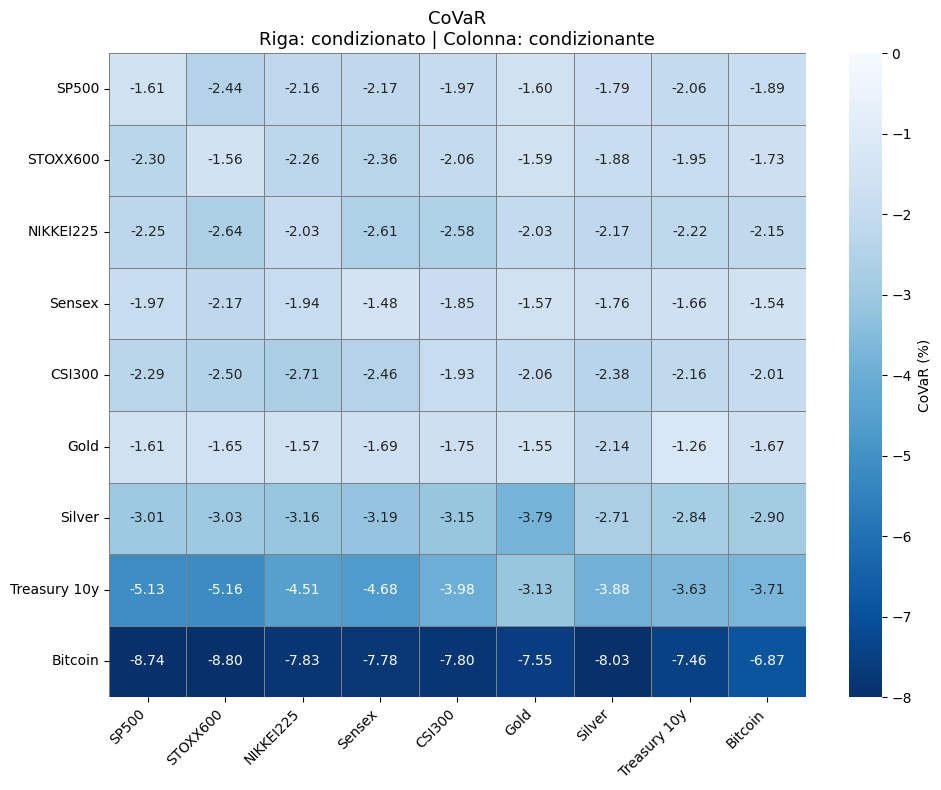

--- Matrice ΔCoVaR ---


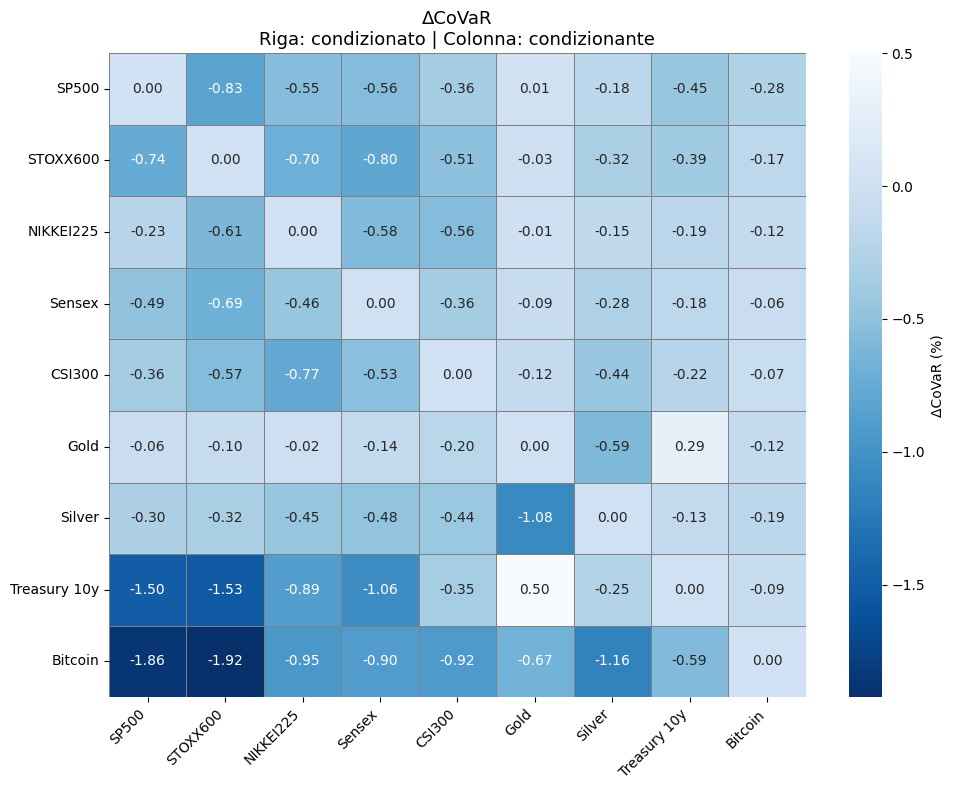

In [ ]:
import pandas as pd
import numpy as np
import warnings
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

FILE_NAME = "indici_tesi_all.xlsx"
QUANTILE_ALPHA = 0.05
QUANTILE_BETA = 0.05

def carica_e_prepara_dati():
    try:
        df = pd.read_excel(FILE_NAME)
        df["Data"] = pd.to_datetime(df["Date"])
        df.set_index("Data", inplace=True)
        df.drop(columns=["Date"], errors="ignore", inplace=True)
        if "CSI300" in df.columns:
            df["CSI300"] = df["CSI300"].replace(0, np.nan)
        df_ret = np.log(df / df.shift(1))
        cols = ["SP500", "STOXX600", "NIKKEI225", "Sensex", "CSI300",
                "Gold", "Silver", "Treasury 10y", "Bitcoin"]
        return df_ret[cols].dropna(how="any")
    except FileNotFoundError:
        print(f"File '{FILE_NAME}' non trovato.")
        return pd.DataFrame()

def calculate_covar_and_delta(Y, X, alpha=QUANTILE_ALPHA, beta=QUANTILE_BETA):
    var_X = X.quantile(alpha)
    X_sm = sm.add_constant(X.values)
    try:
        # disp=0 può essere rimosso se causa problemi, a seconda della versione di statsmodels
        res = sm.QuantReg(Y.values, X_sm).fit(q=beta, disp=0)
        c, b = res.params
    except Exception:
        return np.nan, np.nan
    covar = c + b * var_X
    delta = covar - Y.quantile(beta)
    return covar, delta

def heatmap(matrix, title, vmin=None, vmax=None):
    plt.figure(figsize=(10, 8))
    M = matrix * 100
    sns.heatmap(
        M, annot=True, fmt=".2f", cmap="Blues_r",
        linewidths=.5, linecolor="gray",
        cbar_kws={"label": f"{title} (%)"},
        vmin=vmin,
        vmax=vmax
    )
    plt.title(f"{title}\nRiga: condizionato | Colonna: condizionante", fontsize=13)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    # MODIFICA CHIAVE: Uso di plt.show() per visualizzare direttamente
    plt.show()

if __name__ == "__main__":
    df = carica_e_prepara_dati()
    if df.empty:
        exit()

    assets = df.columns
    n = len(assets)
    covar = pd.DataFrame(np.nan, index=assets, columns=assets)
    delta = pd.DataFrame(np.nan, index=assets, columns=assets)

    for i in range(n):
        for j in range(n):
            X, Y = assets[i], assets[j]
            if i == j:
                covar.loc[Y, X] = df[X].quantile(QUANTILE_BETA)
                delta.loc[Y, X] = 0.0
                continue
            cv, dcv = calculate_covar_and_delta(df[Y], df[X])
            covar.loc[Y, X], delta.loc[Y, X] = cv, dcv

    # CoVaR: Scala fissa per la magnitudo della perdita.
    print("--- Matrice CoVaR ---")
    heatmap(covar, "CoVaR", vmin=-8, vmax=0)

    # Delta CoVaR: Scala dinamica per il contrasto del contributo.
    print("--- Matrice ΔCoVaR ---")
    heatmap(delta, "ΔCoVaR")